# Calculating ground states on large scale systems: Quantum Krylov Subspaces

## Step 1: Map problem to quantum native format

Across disciplines, we're interested in learning ground state properties of quantum systems. Examples include understanding the fundamental nature of particles and forces, predicting and undestanding the behavior of complex materials and understanding bio-chemical interactions and reactions. Because of the exponential growth of the Hilbert space and the correlation that arise in entangled systems, classical algorithm struggle to solve this problem for quantum systems of increasing size. At one end of the spectrum, existing approach that take advantage of the quantum hardware focus on variational quantum methods (e. g. [variational quantum eigen-solver](https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver)). These techniques face challenges with current devices because of the high number of function calls required in the optimization process, which is incompatible with advanced error mitigation techniques, thus limiting their efficacy to small systems. At the other end of the spectrum, there are fault-tolerant quantum methods with performance guarantees (e.g. [quantum phase estimation](https://arxiv.org/pdf/quant-ph/0604193.pdf)) which require deep circuits that can be executed only on a fault-tolerant device. For these reasons, we introduce here a quantum algorithm based on subspace methods (as reviewed [here](https://arxiv.org/pdf/2312.00178.pdf)), the quantum Krylov algorithm. This algorithm performs well at large scale on existing quantum hardware, shares similar [performance guarantees](https://arxiv.org/pdf/2110.07492.pdf) as phase estimation, are compatible with advanced error mitigation techniques and could provide results that are classically inaccessible.

Let us now go into more details of how subspace methods, and the quantum Krylov algorithm in particular, work. Given a matrix $H$ for which we want to know its lowest eigenvalue, subspace methods construct of a smaller representation $\tilde{H}$ of $H$, which captures its properties of interest. In the case of the quantum Krylov algorithm, the Krylov subspace is used to construct the effective representation.

### What is the Krylov subspace? 

By definition, the Krylov subspace $K^r$ of order $r$ is the subspace spanned by vectors obtained by multiplying higher powers of $H$, up to $r-1$, with a reference vector $\vert \psi \rangle$.

$$K^r = \left\{ \vert \psi \rangle, H \vert \psi \rangle, H^2 \vert \psi \rangle, ..., H^{r-1} \vert \psi \rangle \right\}$$

We can gain some insight on why this subspace is interesting by expanding the reference state in terms of the eigenvectors $\vert \lambda_i \rangle$ of the matrix $H$:

$$ \vert \psi \rangle = c_1 \vert \lambda_1 \rangle + c_2 \vert \lambda_2 \rangle + ... + c_n \vert \lambda_n \rangle $$

Applying $j^{th}$ power of the matrix $H$ gives:

$$ H^n \vert \psi \rangle = c_1 \lambda_1^n \vert \lambda_1 \rangle + c_2 \lambda_2^n \vert \lambda_2 \rangle + ... + c_n \lambda_n^n \vert \lambda_n \rangle $$

Which means that the component $k$ with the largest eigenvalue $\lambda_k$ is amplified by the power iteration (This can also be a problem as the basis vector become too similar to each other). The same is true for the smallest eigenvalue, if we consider power iteration of the matrix $H^{-1}$.

### Why is it useful for ground state energy problems?

The Krylov subspace is constructed using the power iteration method. Therefore, states in the Krylov subspace corresponding to the multiplication with higher power of the matrix with the reference states will have the contribution of the ground state $\vert \lambda_k \rangle$ enhanced.


The Krylov subspace that we use classically cannot be accessed on a quantum computer as $H$ is not a unitary matrix. Instead, we can use the time-evolution operator $U = e^{-iHt}$ which can be shown to give similar [convergence guarantees](https://arxiv.org/pdf/2110.07492.pdf) as the power method. Powers of $U$ then become different time steps $U^k = e^{-iH(kt)}$.


$$K_U^r = \left\{ \vert \psi \rangle, U \vert \psi \rangle, U^2 \vert \psi \rangle, ..., U^{r-1} \vert \psi \rangle \right\}$$

The subspace $K_U^r$ obtained in this way is called "Unitary" Krylov subspace.


### How does the algorithm work in summary?

First, we want to find a compact represention of the Hamiltonian in the Krylov subspace $\tilde{H}$. Given that the Krylov subspace has dimension $r$, the Hamiltonian projected into the Krylov subspace will have dimensions $r \times r$. We can then easily diagonalize the projected Hamiltonian $\tilde{H}$. However, we cannot directly diagonalize $\tilde{H}$ because of the non-orthogonality of the Krylov subpace vectors. We'll have to measure their overlaps and construct a matrix $\tilde{S}$ collecting them to do so. We can then  solve the generalized eigenvalue problem

$$ \tilde{H} \ \vec{c} = c \ \tilde{S} \ \vec{c} $$

Where $\tilde{H}=\langle \psi_m \vert H \vert \psi_n \rangle$ is the Hamiltonian matrix in the Krylov subspace $K_D = \left\{ \vert \psi_0 \rangle, \vert \psi_1 \rangle, ..., \vert \psi_D \rangle \right\}$ with dimension $D$, $\vec{c}$ is a vector of variational coefficients that are optimized to get the lowest value of the energy $c_{min}=E_{GS}$ and $\tilde{S}=\langle \psi_m  \vert \psi_n \rangle$ is a matrix of overlaps between states of the Krylov subspace.

Each of the Krylov subspace's vectors are obtained by time-evolving the reference state $\vert \psi \rangle$ under the Hamiltonian $H$ for a certain time: $\vert \psi_l \rangle = U \vert \psi \rangle = e^{-i H t_l}\vert \psi \rangle$. 

We can implement the algorithm on a quantum computer by using the Hadamard test to calculate the matrix elements of $\tilde{H}$ and $\tilde{S}$ as expectation values:

$$\langle \psi_m \vert H \vert \psi_n \rangle = $$
$$= \langle \psi \vert  e^{i H t_m}   H e^{-i H t_n} \vert \psi \rangle$$
$$= \langle \psi \vert  e^{i H m \delta t}   H e^{-i H n \delta t} \vert \psi \rangle$$
$$= \langle \psi \vert H e^{-i H (n-m) \delta t} \vert \psi \rangle$$

### Imports and definitions



In [2]:
import math
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
from typing import Union, List
import warnings
warnings.filterwarnings('ignore')

from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter, MatrixExponential
from qiskit.providers.fake_provider import Fake20QV1
from qiskit.primitives import Estimator

def solve_regularized_gen_eig(h: np.ndarray, s:np.ndarray, threshold: float, k: int =1, return_dimn: bool = False) -> Union[float, List[float]]:
    """
    Method for solving the generalized eigenvalue problem with regularization

    Args:
        h (numpy.ndarray):
            The effective representation of the matrix in the Krylov subspace
        s (numpy.ndarray):
            The matrix of overlaps between vectors of the Krylov subspace
        threshold (float):
            Cut-off value for the eigenvalue of s
        k (int):
            Number of eigenvalues to return
        return_dimn (bool):
            Whether to return the size of the regularized subspace

    Returns:
        lowest k-eigenvalue(s) that are the solution of the regularized generalized eigenvalue problem

    
    """
    s_vals, s_vecs = sp.linalg.eigh(s)
    s_vecs = s_vecs.T
    good_vecs = np.array([vec for val, vec in zip(s_vals, s_vecs) if val > threshold])
    h_reg = good_vecs.conj() @ h @ good_vecs.T
    s_reg = good_vecs.conj() @ s @ good_vecs.T
    if k==1:
        if return_dimn:
            return sp.linalg.eigh(h_reg, s_reg)[0][0], len(good_vecs)
        else:
            return sp.linalg.eigh(h_reg, s_reg)[0][0]
    else:
        if return_dimn:
            return sp.linalg.eigh(h_reg, s_reg)[0][:k], len(good_vecs)
        else:
            return sp.linalg.eigh(h_reg, s_reg)[0][:k]

### Define Hamiltonian
Let's consider the Heisenberg Hamiltonian for $N$ qubits on a linear chain: $H=-J \sum_{i,j}^N Z_i Z_j + J \sum_{i,j}^N X_i X_j + Y_i Y_j$

In [3]:
# Define problem Hamiltonian. Kicked Ising in this case
n_qubits = 10
J = 1 # coupling strength for ZZ interaction

# Define interacting part of the Hamiltonian: sum_ij Z_i Z_j
H_int = [['I']*n_qubits for _ in range(3*(n_qubits-1))]
for i in range(n_qubits-1):
    H_int[i][i] = 'Z'
    H_int[i][i+1] = 'Z'
for i in range(n_qubits-1):
    H_int[n_qubits-1+i][i] = 'X'
    H_int[n_qubits-1+i][i+1] = 'X'
for i in range(n_qubits-1):
    H_int[2*(n_qubits-1)+i][i] = 'Y'
    H_int[2*(n_qubits-1)+i][i+1] = 'Y'
H_int = [''.join(term) for term in H_int]
H_tot = [(term, -J) if term.count('Z') == 2 else (term, 1) for term in H_int]

# Get operator
H_op = SparsePauliOp.from_list(H_tot)
print(H_tot)

[('ZZIIIIIIII', -1), ('IZZIIIIIII', -1), ('IIZZIIIIII', -1), ('IIIZZIIIII', -1), ('IIIIZZIIII', -1), ('IIIIIZZIII', -1), ('IIIIIIZZII', -1), ('IIIIIIIZZI', -1), ('IIIIIIIIZZ', -1), ('XXIIIIIIII', 1), ('IXXIIIIIII', 1), ('IIXXIIIIII', 1), ('IIIXXIIIII', 1), ('IIIIXXIIII', 1), ('IIIIIXXIII', 1), ('IIIIIIXXII', 1), ('IIIIIIIXXI', 1), ('IIIIIIIIXX', 1), ('YYIIIIIIII', 1), ('IYYIIIIIII', 1), ('IIYYIIIIII', 1), ('IIIYYIIIII', 1), ('IIIIYYIIII', 1), ('IIIIIYYIII', 1), ('IIIIIIYYII', 1), ('IIIIIIIYYI', 1), ('IIIIIIIIYY', 1)]


### Set parameters for the algorithm

In [7]:
# Set parameters for quantum Krylov algorithm
krylov_dim = 20 # size of krylov subspace
dt = 0.1 # time step
num_trotter_steps = 4
dt_circ = dt/num_trotter_steps

### State preparation
Pick a reference state $\vert \psi \rangle$ that has some overlap with the ground state. For this Hamiltonian, We use the "checkerboard" state $\vert 0101...01 \rangle$ as our reference.

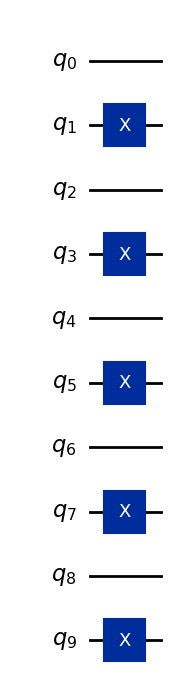

In [8]:
qc_state_prep = QuantumCircuit(n_qubits)
for i in range(n_qubits):
    if i%2 != 0:
        qc_state_prep.x(i)
qc_state_prep.draw('mpl')

### Time evolution

We can realize the time-evolution operator generated by a given Hamiltonian: $U=e^{-iHt}$ via the [Suzuki-Trotter approximation]((https://docs.quantum.ibm.com/api/qiskit/qiskit.synthesis.SuzukiTrotter)).

In [9]:
t = Parameter('t')

## Create the time-evo op circuit
evol_gate = PauliEvolutionGate(H_op, time=t, synthesis=SuzukiTrotter(order=num_trotter_steps) )

qr = QuantumRegister(n_qubits)
qc_evol = QuantumCircuit(qr)
qc_evol.append(evol_gate, qargs=qr)


### Hadamard test

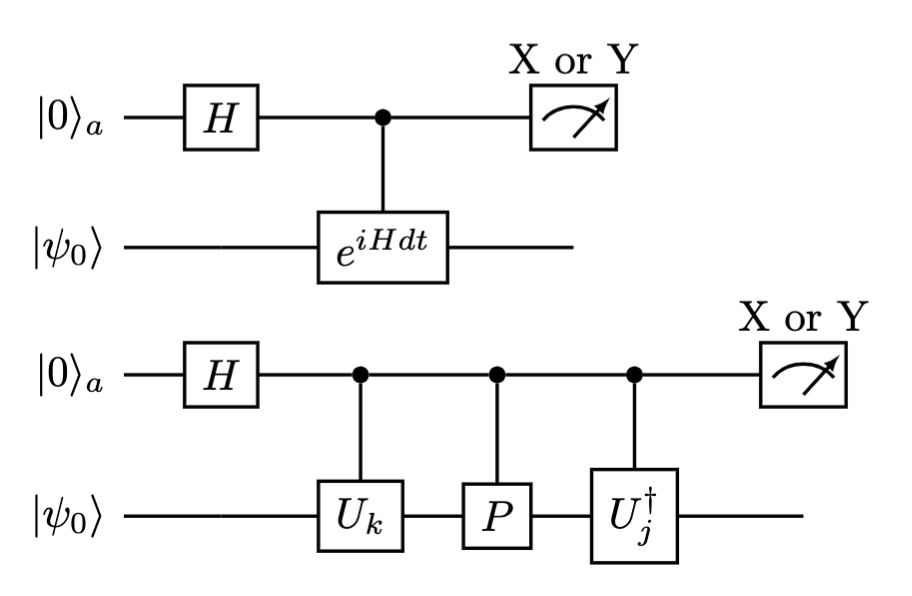


\begin{equation}
    |0\rangle_a|\psi_0\rangle\quad\longrightarrow\quad\frac{1}{\sqrt{2}}\Big(|0\rangle+|1\rangle\Big)_a|\psi_0\rangle\quad\longrightarrow\quad\frac{1}{\sqrt{2}}\Big(|0\rangle_a|\psi_0\rangle+|1\rangle_aU_j^\dagger PU_k|\psi_0\rangle\Big)
\end{equation}
Where $P$ is one of the terms in the decomposition of the Hamiltonian $H=\sum P$. To measure $X$, first apply $H$...
\begin{equation}
    \longrightarrow\quad\frac{1}{2}|0\rangle_a\Big(|\psi_0\rangle+U_j^\dagger PU_k|\psi_0\rangle\Big) + \frac{1}{2}|1\rangle_a\Big(|\psi_0\rangle-U_j^\dagger PU_k|\psi_0\rangle\Big)
\end{equation}
... then measure:
\begin{equation}
\begin{split}
    \Rightarrow\quad\langle X\rangle_a &= \frac{1}{4}\Bigg(\Big\||\psi_0\rangle+U_j^\dagger PU_k|\psi_0\rangle\Big\|^2-\Big\||\psi_0\rangle-U_j^\dagger PU_k|\psi_0\rangle\Big\|^2\Bigg) \\
    &= \text{Re}\Big[\langle\psi_0|U_j^\dagger PU_k|\psi_0\rangle\Big].
\end{split}
\end{equation}
Similarly, measuring $Y$ yields
\begin{equation}
    \langle Y\rangle_a = \text{Im}\Big[\langle\psi_0|U_j^\dagger PU_k|\psi_0\rangle\Big].
\end{equation}

Circuit for calculating the real part of the overlap in S via Hadamard test


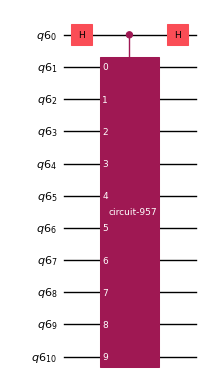

In [10]:
## Create the time-evo op circuit
evol_gate = PauliEvolutionGate(H_op, time=dt, synthesis= SuzukiTrotter(order=num_trotter_steps) ) #MatrixExponential exact matrix exp, SuzukiTrotter(order=2) for order-2 Trotter evo op

## Create the time-evo op dagger circuit
evol_gate_d = PauliEvolutionGate(H_op, time=dt, synthesis= SuzukiTrotter(order=num_trotter_steps) )
evol_gate_d = evol_gate_d.inverse()

# Put pieces together
qc_reg = QuantumRegister(n_qubits)
qc_temp = QuantumCircuit(qc_reg)
qc_temp.compose(qc_state_prep, inplace=True)
for _ in range(num_trotter_steps):
    qc_temp.append(evol_gate, qargs=qc_reg)
for _ in range(num_trotter_steps):
    qc_temp.append(evol_gate_d, qargs=qc_reg)
qc_temp.compose(qc_state_prep.inverse(), inplace=True)

# Create controlled version of the circuit
controlled_U = qc_temp.to_gate().control(1)

# Create hadamard test circuit for real part
qr = QuantumRegister(n_qubits+1)
qc_real = QuantumCircuit(qr)
qc_real.h(0)
qc_real.append(controlled_U, list(range(n_qubits+1)))
qc_real.h(0)

print('Circuit for calculating the real part of the overlap in S via Hadamard test')
qc_real.draw('mpl', fold=-1, scale=0.5)

The Hadamard test circuit can be a deep circuit once we transpile to native gates and topology of a device. For example the 5 qubits case considered here 

In [11]:
circuit_trans_unopt = transpile(circuits=qc_real.decompose().decompose(), backend=Fake20QV1())

print('The circuit has 2Q gates depth: ', circuit_trans_unopt.depth(lambda x: x[0].num_qubits == 2))


The circuit has 2Q gates depth:  78772


## Step 2: Optimize circuits and operators

We can optimize the deep circuits for the Hadamard test that we have obtained by introducing some approximations and relying on some assumption about the model Hamiltonian. For example, consider the following circuit for the Hadamard test:


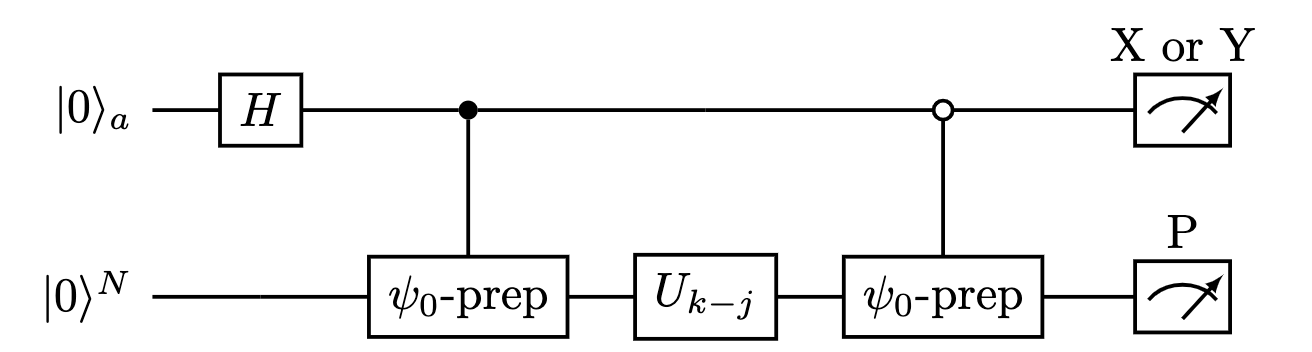

Assume we can classically calculate $E_0$, the eigenvalue of $|0\rangle^N$ under the Hamiltonian $H$.
This is satisfied when the Hamiltonian preserves the U(1) symmetry.
Assume that the gate $\psi_0-prep$ prepares our desired reference state $\ket{\psi_0}$, e.g., to prepare the HF state for chemistry $\psi_0-prep$ would be a product of single-qubit NOTs, so controlled-$\psi_0-prep$ is just a product of CNOTs.
Then the circuit above implements the following state prior to measurement:

\begin{equation}
\begin{split}
    \ket{0} \ket{0}^N\xrightarrow{H}&\frac{1}{\sqrt{2}}
    \left(
    \ket{0}\ket{0}^N+ \ket{1} \ket{0}^N
    \right)\\
    \xrightarrow{\text{1-ctrl-init}}&\frac{1}{\sqrt{2}}\left(|0\rangle|0\rangle^N+|1\rangle|\psi_0\rangle\right)\\
    \xrightarrow{U}&\frac{1}{\sqrt{2}}\left(e^{i\phi}\ket{0}\ket{0}^N+\ket{1} U\ket{\psi_0}\right)\\
    \xrightarrow{\text{0-ctrl-init}}&\frac{1}{\sqrt{2}}
    \left(
    e^{i\phi}\ket{0} \ket{\psi_0}
    +\ket{1} U\ket{\psi_0}
    \right)\\
    =&\frac{1}{2}
    \left(
    \ket{+}\left(e^{i\phi}\ket{\psi_0}+U\ket{\psi_0}\right)
    +\ket{-}\left(e^{i\phi}\ket{\psi_0}-U\ket{\psi_0}\right)
    \right)\\
    =&\frac{1}{2}
    \left(
    \ket{+i}\left(e^{i\phi}\ket{\psi_0}-iU\ket{\psi_0}\right)
    +\ket{-i}\left(e^{i\phi}\ket{\psi_0}+iU\ket{\psi_0}\right)
    \right)
\end{split}
\end{equation}

where we have used the classical simulable phase shift $ U\ket{0}^N = e^{i\phi}\ket{0}$ in the third line. Therefore the expectation values are obtained as

\begin{equation}
\begin{split}
    \langle X\otimes P\rangle&=\frac{1}{4}
    \Big(
    \left(e^{-i\phi}\bra{\psi_0}+\bra{\psi_0}U^\dagger\right)P\left(e^{i\phi}\ket{\psi_0}+U\ket{\psi_0}\right)
    \\
    &\qquad-\left(e^{-i\phi}\bra{\psi_0}-\bra{\psi_0}U^\dagger\right)P\left(e^{i\phi}\ket{\psi_0}-U\ket{\psi_0}\right)
    \Big)\\
    &=\text{Re}\left[e^{-i\phi}\bra{\psi_0}PU\ket{\psi_0}\right],
\end{split}
\end{equation}

\begin{equation}
\begin{split}
    \langle Y\otimes P\rangle&=\frac{1}{4}
    \Big(
    \left(e^{-i\phi}\bra{\psi_0}+i\bra{\psi_0}U^\dagger\right)P\left(e^{i\phi}\ket{\psi_0}-iU\ket{\psi_0}\right)
    \\
    &\qquad-\left(e^{-i\phi}\bra{\psi_0}-i\bra{\psi_0}U^\dagger\right)P\left(e^{i\phi}\ket{\psi_0}+iU\ket{\psi_0}\right)
    \Big)\\
    &=\text{Im}\left[e^{-i\phi}\bra{\psi_0}PU\ket{\psi_0}\right].
\end{split}
\end{equation}


### Decompose time-evolution operator with Suzuki-Trotter decomposition
Instead of implementing the time-evolution operator exactly we can use the Suzuki-Trotter decomposition to implement an approximation of it. Repeating several times a certain order Trotter decomposition gives us further reduction of the error introduced from the approximation. In the following, we directly build the Trotter implementation in the most efficient way for the interaction graph of the Hamiltonian we are considering (nearest neighbor interactions only). In practice we insert Pauli rotations $R_{xx}$, $R_{yy}$, $R_{zz}$ with a parametrized angle $t$ which correspond to the approximate implementation of $e^{-i (XX + YY -ZZ) t}$. This gives a much shallower circuit than what is obtained using the generic `PauliEvolutionGate()` functionality. 

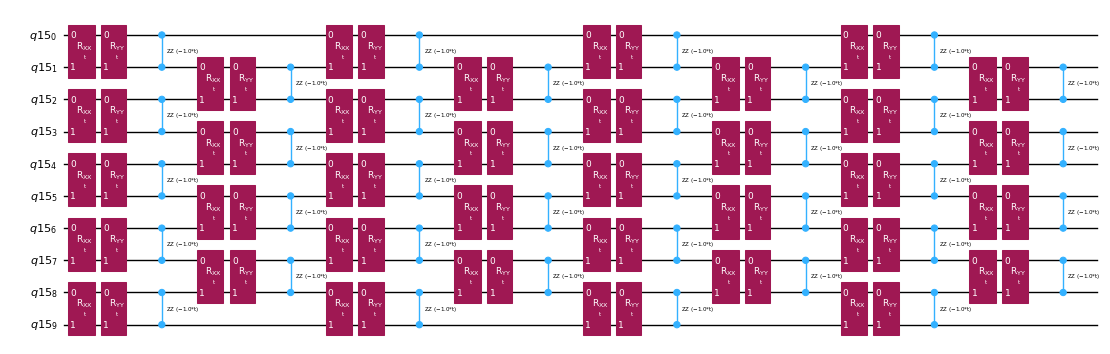

In [12]:
t = Parameter('t')

# Create instruction for rotation about XX+YY-ZZ:
Rxyz_circ = QuantumCircuit(2)
Rxyz_circ.rxx(t,0,1)
Rxyz_circ.ryy(t,0,1)
Rxyz_circ.rzz(-t,0,1)
Rxyz_instr = Rxyz_circ.to_instruction(label='RXX+YY-ZZ')

interaction_list = [[[i, i+1] for i in range(0, n_qubits-1, 2)], [[i, i+1] for i in range(1, n_qubits-1, 2)]] # linear chain

qr = QuantumRegister(n_qubits)
trotter_step_circ = QuantumCircuit(qr)
for i, color in enumerate(interaction_list):
    for interaction in color:
        trotter_step_circ.append(Rxyz_instr, interaction)


qc_evol = QuantumCircuit(qr)
for _ in range(num_trotter_steps):
    qc_evol.compose(trotter_step_circ, inplace=True)

qc_evol.decompose().draw('mpl', fold=-1, scale = 0.5)

### Use an optimized circuit for state preparation

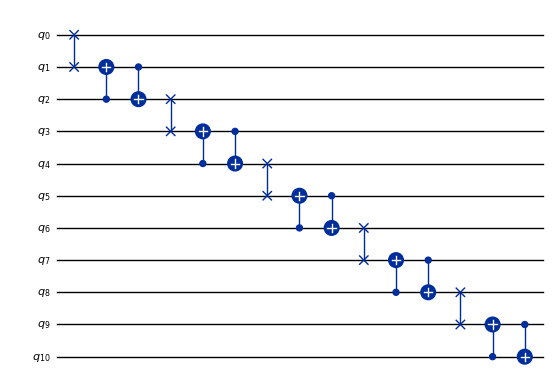

In [14]:
controlled_state_prep = QuantumCircuit(n_qubits + 1)
for idx in range(n_qubits):
    if idx % 2 == 0:
        controlled_state_prep.swap(idx, idx+1)
    else:
        controlled_state_prep.cx(idx+1, idx)
        controlled_state_prep.cx(idx, idx+1)


controlled_state_prep.draw('mpl', fold=-1, scale=0.5)

### Template circuits for calculating matrix elements of $\tilde{S}$ via Hadamard test

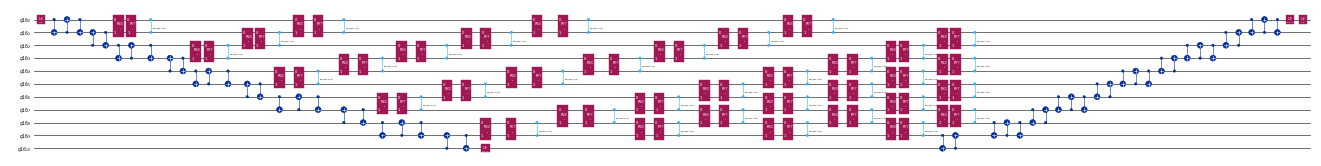

In [15]:
# Create hadamard test circuit for real part
qr = QuantumRegister(n_qubits+1)
qc_real = QuantumCircuit(qr)
qc_real.h(0)
qc_real.compose(controlled_state_prep, list(range(n_qubits+1)), inplace=True)
qc_real.x(n_qubits)
qc_real.compose(qc_evol, list(range(n_qubits)), inplace=True)
qc_real.compose(controlled_state_prep.inverse(), list(range(n_qubits+1)), inplace=True)
qc_real.x(0)
qc_real.h(0)

S_real_circ = qc_real.decompose().copy()

# # Create hadamard test circuit for imaginary part
qr = QuantumRegister(n_qubits+1)
qc_imag = QuantumCircuit(qr)
qc_imag.h(0)
qc_imag.sdg(0)
qc_imag.compose(controlled_state_prep, list(range(n_qubits+1)), inplace=True)
qc_imag.x(n_qubits)
qc_imag.compose(qc_evol, list(range(n_qubits)), inplace=True)
qc_imag.compose(controlled_state_prep.inverse(), list(range(n_qubits+1)), inplace=True)
qc_imag.x(0)
qc_imag.h(0)


S_imag_circ = qc_imag.decompose().copy()

S_real_circ.draw('mpl', fold=-1, scale = 0.2)

In [16]:
circuit_trans_opt = transpile(S_real_circ.decompose().decompose(), Fake20QV1())

print('The optimized circuit has 2Q gates depth: ', circuit_trans_opt.depth(lambda x: x[0].num_qubits ==2))
print('Compared to the unoptimized circuit depth of', circuit_trans_unopt.depth(lambda x: x[0].num_qubits == 2))

The optimized circuit has 2Q gates depth:  96
Compared to the unoptimized circuit depth of 78772


We have considerably reduced the depth of the Hadamard test with a combination of Trotter approximation and uncontrolled unitaries

### Template circuits for calculating matrix elements of $\tilde{H}$ via Hadamard test
The only difference between the circuits used in the Hadamard test will be the phase in the time-evolution operator and the observables measured. Therefore we can prepare a template circuit which represent the generic circuit for the Hadamard test, with placeholders for the gates that depend on the time-evolution operator.


In [24]:
# Hamiltonian terms to measure
observable_list = []
for idx_ket in range(krylov_dim):
    for idx_bra in range(idx_ket + 1):
        for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
            # print(pauli)
            observable = pauli[::-1].to_label() + 'Z'
            observable_list.append(observable)



# Real part
# First half hadamard test
qr = QuantumRegister(n_qubits+1)
qc_real_1 = QuantumCircuit(qr)
qc_real_1.h(0)
qc_real_1.compose(controlled_state_prep, list(range(n_qubits+1)), inplace=True)
qc_real_1.x(n_qubits)
qc_real_1.compose(qc_evol, list(range(n_qubits)), inplace=True)    
H_real_circ_1 = qc_real_1.decompose().copy()

# Second half hadamard test
qr = QuantumRegister(n_qubits+1)
qc_real_2 = QuantumCircuit(qr)
qc_real_2.compose(controlled_state_prep.inverse(), list(range(n_qubits+1)), inplace=True)
qc_real_2.x(0)
qc_real_2.h(0)
H_real_circ_2 = qc_real_2.decompose().copy()

# Imaginary part
# First half hadamard test
qr = QuantumRegister(n_qubits+1)
qc_imag_1 = QuantumCircuit(qr)
qc_imag_1.h(0)
qc_imag_1.compose(controlled_state_prep, list(range(n_qubits+1)), inplace=True)
qc_imag_1.x(n_qubits)
qc_imag_1.compose(qc_evol, list(range(n_qubits)), inplace=True)    
H_imag_circ_1 = qc_imag_1.decompose().copy()

# Second half hadamard test
qr = QuantumRegister(n_qubits+1)
qc_imag_2 = QuantumCircuit(qr)
qc_imag_2.compose(controlled_state_prep.inverse(), list(range(n_qubits+1)), inplace=True)
qc_imag_2.x(0)
qc_imag_2.sdg(0)
qc_imag_2.h(0)
H_imag_circ_2 = qc_imag_2.decompose().copy()


## Step 3: Execute using a quantum primitive

Generate circuits to calculate all matrix elements of $\tilde{S}$

In [26]:
S_real_circuits, S_imag_circuits = [], []
for idx_ket in range(krylov_dim):
    for idx_bra in range(idx_ket + 1):

        circuit_real = S_real_circ.assign_parameters({t: dt_circ*(idx_ket-idx_bra)})
        circuit_imag = S_imag_circ.assign_parameters({t: dt_circ*(idx_ket-idx_bra)})

        S_real_circuits.append(circuit_real)
        S_imag_circuits.append(circuit_imag)

And $\tilde{H}$

In [27]:
count = 0
H_real_circuits, H_imag_circuits = [], []    
for idx_ket in range(krylov_dim):
    for idx_bra in range(idx_ket + 1):
        for pauli, coeff in zip(H_op.paulis, H_op.coeffs):

            circuit_real = H_real_circ_1
            circuit_real = circuit_real.compose(H_real_circ_2, list(range(n_qubits+1)))
            circuit_real = circuit_real.assign_parameters({t: dt_circ*(idx_ket-idx_bra)})

            circuit_imag = H_imag_circ_1
            circuit_imag = circuit_imag.compose(H_imag_circ_2, list(range(n_qubits+1)))
            circuit_imag = circuit_imag.assign_parameters({t: dt_circ*(idx_ket-idx_bra)})

            H_real_circuits.append(circuit_real)
            H_imag_circuits.append(circuit_imag)

            count+=1

Execute circuits for $\tilde{S}$ with the Estimator

In [28]:
estimator = Estimator()

jobs = {'S': {'real':[], 'imag':[]},
        'H': {'real':[], 'imag':[]}
        } # store executed jobs


shots = 100000
observable = 'I'*(n_qubits) + 'Z'

job_size_S = 20
job_idxs_S = [idx for idx in range(0, math.ceil(len(S_real_circuits)/job_size_S)+1)]



print(len(S_real_circuits), 'circuits to run')

S_real_results_list, S_imag_results_list = [], []
for i in range(len(job_idxs_S)-1):

    job = estimator.run(S_real_circuits[job_idxs_S[i]*job_size_S:job_idxs_S[i+1]*job_size_S], observables = [observable]*len(S_real_circuits[job_idxs_S[i]*job_size_S:job_idxs_S[i+1]*job_size_S]), shots=shots)
    jobs['S']['real'].append(job.job_id())
    S_real_results = job.result()

    job = estimator.run(S_imag_circuits[job_idxs_S[i]*job_size_S:job_idxs_S[i+1]*job_size_S], observables = [observable]*len(S_imag_circuits[job_idxs_S[i]*job_size_S:job_idxs_S[i+1]*job_size_S]), shots=shots)
    jobs['S']['imag'].append(job.job_id())
    S_imag_results = job.result()


    S_real_results_list.append(S_real_results); S_imag_results_list.append(S_imag_results)


210 circuits to run


And for $\tilde{H}$

In [29]:
estimator = Estimator()

jobs['H']['real'], jobs['H']['imag'] = [], []
shots = 100000


job_size = 50
job_idxs = [idx for idx in range(0, math.ceil(len(H_real_circuits)/job_size)+1)]

print(len(H_imag_circuits), 'circuits to run')

H_real_results_list, H_imag_results_list = [], []
for i in range(len(job_idxs)-1):


    job_real = estimator.run(H_real_circuits[job_idxs[i]*job_size:job_idxs[i+1]*job_size], observables = observable_list[job_idxs[i]*job_size:job_idxs[i+1]*job_size], shots=shots)
    jobs['H']['real'].append(job_real.job_id())
    H_real_results = job_real.result()

    job_imag = estimator.run(H_imag_circuits[job_idxs[i]*job_size:job_idxs[i+1]*job_size], observables = observable_list[job_idxs[i]*job_size:job_idxs[i+1]*job_size], shots=shots)
    jobs['H']['imag'].append(job_imag.job_id())
    H_imag_results = job_imag.result()


    H_real_results_list.append(H_real_results); H_imag_results_list.append(H_imag_results)


5670 circuits to run


## Step 4: Post-process and analyze results

Once we have the results of the circuit executions we can post-process the data to calculate the matrix elements of $\tilde{S}$

In [30]:
S_circ = np.zeros((krylov_dim, krylov_dim), dtype=complex)
count = 0
for idx_ket in range(krylov_dim):
    for idx_bra in range(idx_ket + 1):

        eff_count = count % (job_size_S)
        res_idx = count // (job_size_S)

        S_real_results = S_real_results_list[res_idx]
        S_imag_results = S_imag_results_list[res_idx]

        # Get expectation values from experiment
        expval_real = S_real_results.values[eff_count]
        expval_imag = S_imag_results.values[eff_count]

        # Get expectation values
        expval = expval_real + 1j*expval_imag

        # Fill-in matrix elements
        S_circ[idx_bra, idx_ket] = expval
        S_circ[idx_ket, idx_bra] = expval.conjugate()




        count+=1

And the matrix elements of $\tilde{H}$

In [31]:
H_eff_circ = np.zeros((krylov_dim, krylov_dim), dtype=complex)
count = 0
for idx_ket in range(krylov_dim):
    for idx_bra in range(idx_ket + 1):
        for pauli, coeff in zip(H_op.paulis, H_op.coeffs):

            eff_count = count % (job_size)
            res_idx = count // (job_size)

            H_real_results = H_real_results_list[res_idx]
            H_imag_results = H_imag_results_list[res_idx]

            # Get expectation values from experiment
            expval_real = H_real_results.values[eff_count]
            expval_imag = H_imag_results.values[eff_count]

            # # Get expectation values
            expval = expval_real + 1j*expval_imag


            # Fill-in matrix elements
            H_eff_circ[idx_bra, idx_ket] += coeff*expval
            if idx_bra != idx_ket: # don't duplicate terms on diagonal
                H_eff_circ[idx_ket, idx_bra] += (coeff*expval).conjugate()



            count+=1

Finally, we can solve the generalized eigenvalue problem for $\tilde{H}$:

$$\tilde{H} \vec{c} = c \tilde{S} \vec{c}$$

and get an estimate of the ground state energy $c_{min}$

In [32]:
gnd_en_circ_est_list = []
for d in range(1, krylov_dim+1):
    # Solve generalized eigenvalue problem
    gnd_en_circ_est = solve_regularized_gen_eig(H_eff_circ[:d, :d], S_circ[:d, :d], threshold=1e-2)
    gnd_en_circ_est_list.append(gnd_en_circ_est)
    print('The estimated ground state energy is: ', gnd_en_circ_est)

The estimated ground state energy is:  9.02350357851545
The estimated ground state energy is:  1.3661212194478773
The estimated ground state energy is:  1.5519667772645285
The estimated ground state energy is:  -2.433030660377216
The estimated ground state energy is:  -3.8243769047376768
The estimated ground state energy is:  -3.093617946223878
The estimated ground state energy is:  -5.141259443945021
The estimated ground state energy is:  -6.327974564731133
The estimated ground state energy is:  -6.219471601689204
The estimated ground state energy is:  -6.585432430537937
The estimated ground state energy is:  -6.995995439961133
The estimated ground state energy is:  -7.193648275003521
The estimated ground state energy is:  -7.577746195049643
The estimated ground state energy is:  -7.375626245886178
The estimated ground state energy is:  -7.633870979679662
The estimated ground state energy is:  -7.765358735198269
The estimated ground state energy is:  -8.061082731107005
The estimated g

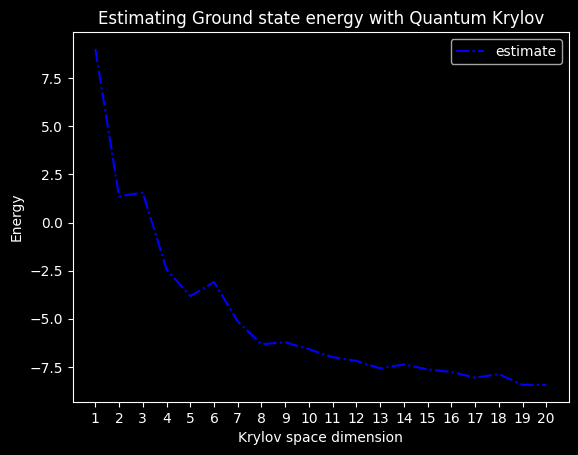

In [33]:
plt.plot(range(1, krylov_dim+1), gnd_en_circ_est_list, color = 'blue', linestyle='-.' , label = 'estimate')
plt.xticks(range(1, krylov_dim+1), range(1, krylov_dim+1))
plt.legend()
plt.xlabel('Krylov space dimension')
plt.ylabel('Energy')
plt.title('Estimating Ground state energy with Quantum Krylov')
plt.show()